#

Formula Trinity DUCSS - Object Detection

how to make a traffic cone detector using [PyTorch](https://pytorch.org/).

This notebook was adapted from the one in [Fine-tuning Faster-RCNN using pytorch](https://www.kaggle.com/yerramvarun/fine-tuning-faster-rcnn-using-pytorch/notebook)



## Installs and Imports

Install and import PyTorch along with a few helper libraries

Let's install some dependencies and clone the [TorchVision Repo](https://github.com/pytorch/vision) so we can use some helper files

In [1]:
!pwd
!ls

/notebooks/ml635e2/ml635h
__pycache__	  data.rar   more		     pyt_635h4-ir3.ipynb  x
cast04v3yolo	  engine.py  outmodel.pth	     transforms.py
cast04v3yolo.zip  img	     outmodelstate.pth	     utils.py
coco_eval.py	  img1	     pyt_635h3.ipynb	     v-img
coco_utils.py	  ir3	     pyt_635h4-cast04.ipynb  vision


In [4]:
!pwd
# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0

/notebooks/ml635e2/635h
Cloning into 'vision'...
remote: Enumerating objects: 154831, done.
remote: Counting objects: 100% (7204/7204), done.
remote: Compressing objects: 100% (636/636), done.
remote: Total 154831 (delta 6610), reused 7069 (delta 6538), pack-reused 147627
Receiving objects: 100% (154831/154831), 306.64 MiB | 20.50 MiB/s, done.
Resolving deltas: 100% (137189/137189), done.
Updating files: 100% (816/816), done.
/notebooks/ml635e2/635h/vision


In [4]:
%%bash
apt update
DEBIAN_FRONTEND=noninteractive apt-get install -y python3-opencv
#tz prompt. dpkg fix...
pip install opencv-python
#pip install cv2

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 http://ppa.launchpad.net/git-core/ppa/ubuntu bionic InRelease [20.8 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [22.8 kB]
Get:5 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [982 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1515 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2830 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:10 http://ppa.launchpad.net/git-core/ppa/ubuntu bionic/main amd64 Packages [3163 B]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [2290 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [3262 kB]
Get:13 http://archi



debconf: delaying package configuration, since apt-utils is not installed


In [5]:
# Install dependencies and 
!pip install albumentations==0.4.6
!pip install pycocotools --quiet
!pwd



     |████████████████████████████████| 117 kB 29.4 MB/s eta 0:00:01
     |████████████████████████████████| 948 kB 29.6 MB/s eta 0:00:01     |█████████████████████████▎      | 747 kB 29.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 27.2 MB/s eta 0:00:01
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65173 sha256=720e993651aea51a3e06d162e1fb89e0b71e0866318f5e9047ae30578f796796
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.1.0
    Uninstalling albumentations-1.1.0:
      Successfully uninstalled albumentations-1.1.0
/notebooks/ml635e2/ml635h


In [ ]:

%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./
!pwd


Lets import the libraries

In [2]:
# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


## The Dataset 

Having a good dataset is essential to training an accurate model. However, just possessing the dataset is not enough. We must pre-process it so that it can be fed to the neural network - and then understood by it.

Finding an existing dataset can sometimes be very difficult. When searching for your dataset you may run into the following problems:

* **Broken links**: even if someone has open-sourced something, links they previously had to their datasets often end up becoming stale.
* **Poor Open-Source Practice**: some "open-source" dataset providers will insist on you contributing to the dataset to be provided access.

However, keep searching! Here's some tricks:

* **Search specific websites**: When searching on Google, you can search specifically on GitHub by searching something like: `cone detection dataset site:github.com`.
* **Reading other people's code**: Try to find the code of someone else that worked on a similar problem, and see if you can find out what dataset they used! Such as searching: `image classification on traffic cones` and trying to find other notebooks.


We found the dataset for this worksop by scouring GitHub repos. It contains 123 annotated images in the training set and 

Let's download it!

In [12]:
!pwd 
!apt install wget unrar


/notebooks/ml635e2/635h
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  unrar wget
0 upgraded, 2 newly installed, 0 to remove and 76 not upgraded.
Need to get 445 kB of archives.
After this operation, 1276 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 wget amd64 1.19.4-1ubuntu2.2 [316 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 unrar amd64 1:5.5.8-1 [129 kB]
Fetched 445 kB in 1s (671 kB/s)
debconf: delaying package configuration, since apt-utils is not installed

78Selecting previously unselected package wget.
(Reading database ... 35823 files and directories currently installed.)
Preparing to unpack .../wget_1.19.4-1ubuntu2.2_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  9%] [#####.....................................................] 8Unpac

In [16]:
!wget -O data.rar https://www.dropbox.com/sh/ay9wf7ii81q5zif/AADwIb9HkvpBmUDJvKpNl0Xna?dl=0&file_subpath=%2Fimg&preview=data.rar#:~:text=Sign%20up-,Direct,-download
#!unrar x data.rar
# image 96 had no annotations, so we'll delete it!
!rm img/96.jpg
!ls -la
!pwd


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from data.rar

Creating    v-img                                                     OK
Extracting  v-img/137.jpg                                                0  OK 
Extracting  v-img/137.txt                                                0  OK 
Extracting  v-img/140.jpg                                                0  OK 
Extracting  v-img/140.txt                                                0  OK 
Extracting  v-img/159.jpg                                                1  OK 
Extracting  v-img/159.txt                                                1  OK 
Extracting  v-img/218.jpg                                                2  OK 
Extracting  v-img/218.txt                                                2  OK 
Extracting  v-img/232.jpg                                                2  OK 
Extracting  v-img/232.txt                                                2  OK 
Extracting  v-img/236.jpg       

Extracting  img/15.txt                                                  22  OK 
Extracting  img/150.jpg                                                 23  OK 
Extracting  img/150.txt                                                 23  OK 
Extracting  img/151.jpg                                                 23  OK 
Extracting  img/151.txt                                                 23  OK 
Extracting  img/155.jpg                                                 24  OK 
Extracting  img/155.txt                                                 24  OK 
Extracting  img/158.jpg                                                 25  OK 
Extracting  img/158.txt                                                 25  OK 
Extracting  img/161.jpg                                                 26  OK 
Extracting  img/161.txt                                                 26  OK 
Extracting  img/162.jpg                                                 27  OK 
Extracting  img/162.txt                 

Extracting  img/53.jpg                                                  51  OK 
Extracting  img/53.txt                                                  51  OK 
Extracting  img/54.jpg                                                  51  OK 
Extracting  img/54.txt                                                  51  OK 
Extracting  img/55.jpg                                                  52  OK 
Extracting  img/55.txt                                                  52  OK 
Extracting  img/57.jpg                                                  52  OK 
Extracting  img/57.txt                                                  52  OK 
Extracting  img/6.jpg                                                   52  OK 
Extracting  img/6.txt                                                   52  OK 
Extracting  img/60.jpg                                                  52  OK 
Extracting  img/60.txt                                                  52  OK 
Extracting  img/66.jpg                  

Extracting  img1/cone3042.jpg                                           95  OK 
Extracting  img1/cone3042.txt                                           95  OK 
Extracting  img1/cone3043.jpg                                           96  OK 
Extracting  img1/cone3043.txt                                           96  OK 
Extracting  img1/cone3044.jpg                                           97  OK 
Extracting  img1/cone3044.txt                                           97  OK 
Extracting  img1/cone3045.jpg                                           98  OK 
Extracting  img1/cone3045.txt                                           98  OK 
Extracting  img1/cone3046.jpg                                           99  OK 
Extracting  img1/cone3046.txt                                           99  OK 
Extracting  img1/cone3047.jpg                                           99  OK 
Extracting  img1/cone3047.txt                                           99  OK 
All OK
total 19210
drwxr-xr-x 8 root roo

In [13]:
    awidth = 2
    print ('w=', width)

w= 2


In [22]:
# defining the files directory and testing directory
files_dir = './cast04v3yolo/train/'
test_dir = '/cast04v3yolo/test/'

# we create a Dataset class which has a __getitem__ function and a __len__ function
class ConeImagesDataset(torch.utils.data.Dataset):

  def __init__(self, files_dir, width, height, transforms=None):
    self.transforms = transforms
    self.files_dir = files_dir
    self.height = height
    self.width = width
    print ('w=',width,'h=',height)
    
    # sorting the images for consistency
    # To get images, the extension of the filename is checked to be jpg
    self.imgs = [image for image in sorted(os.listdir(files_dir)) if image[-4:]=='.jpg']
    
    # classes: 0 index is reserved for background
    self.classes = [_, 'Void']

  def __getitem__(self, idx):
    img_name = self.imgs[idx]
    image_path = os.path.join(self.files_dir, img_name)

    # reading the images and converting them to correct size and color    
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    #img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
    img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
    # diving by 255
    img_res /= 255.0
    
    # annotation file
    annot_filename = img_name[:-4] + '.txt'
    annot_file_path = os.path.join(self.files_dir, annot_filename)
    
    boxes = []
    labels = []
    
    # cv2 image gives size as height x width
    wt = img.shape[1]
    ht = img.shape[0]
    
    # box coordinates for xml files are extracted and corrected for image size given
    with open(annot_file_path) as f:
      for line in f:
        labels.append(1)
        
        parsed = [float(x) for x in line.split(' ')]
        x_center = parsed[1]
        y_center = parsed[2]
        box_wt = parsed[3]
        box_ht = parsed[4]

        xmin = x_center - box_wt/2
        xmax = x_center + box_wt/2
        ymin = y_center - box_ht/2
        ymax = y_center + box_ht/2
        
        xmin_corr = int(xmin*self.width)
        xmax_corr = int(xmax*self.width)
        ymin_corr = int(ymin*self.height)
        ymax_corr = int(ymax*self.height)
        
        boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
    
    # convert boxes into a torch.Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    
    # getting the areas of the boxes
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

    # suppose all instances are not crowd
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
    
    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["area"] = area
    target["iscrowd"] = iscrowd
    image_id = torch.tensor([idx])
    target["image_id"] = image_id

    if self.transforms:
      sample = self.transforms(image = img_res,
                                bboxes = target['boxes'],
                                labels = labels)
      img_res = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])
        
    return img_res, target

  def __len__(self):
    return len(self.imgs)


# check dataset
dataset = ConeImagesDataset(files_dir, 512, 512)
print('Length of dataset:', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[0]
print('Image shape:', img.shape)
print('Label example:', target)

w= 512 h= 512
Length of dataset: 50 

Image shape: (512, 512, 3)
Label example: {'boxes': tensor([[201., 386., 223., 401.]]), 'labels': tensor([1]), 'area': tensor([330.]), 'iscrowd': tensor([0]), 'image_id': tensor([0])}


# Visualization

Let's make some a helper function to view our data

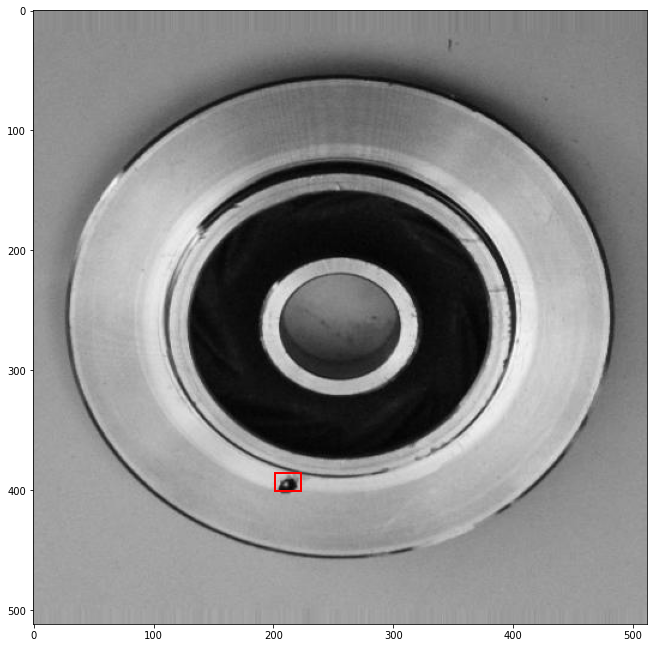

In [23]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(11,22)
  a.imshow(img)
  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    a.add_patch(rect)
  plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[0]
plot_img_bbox(img, target)

# Augmentations

This is where we can apply augmentations to the image. 

The augmentations to object detection vary from normal augmentations becuase here we need to ensure that, bbox still aligns with the object correctly after transforming.

Here we are doing a random flip transform.



In [24]:
# Send train=True for training transforms and False for val/test transforms
def get_transform(train):
  if train:
    return A.Compose(
      [
        A.HorizontalFlip(0.5),
        # ToTensorV2 converts image to pytorch tensor without div by 255
        ToTensorV2(p=1.0) 
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )
  else:
    return A.Compose(
      [ToTensorV2(p=1.0)],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

# Dataloaders

Make a loader for feeding our data into the neural network

Now lets prepare the datasets and dataloaders for training and testing.

In [25]:
# use our dataset and defined transformations
dataset = ConeImagesDataset(files_dir, 512, 512, transforms=get_transform(train=True))
dataset_test = ConeImagesDataset(files_dir, 512, 512, transforms=get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.25
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=10,
  shuffle=True,
  num_workers=4,
  collate_fn=utils.collate_fn,
)

data_loader_test = torch.utils.data.DataLoader(
  dataset_test,
  batch_size=10,
  shuffle=False,
  num_workers=4,
  collate_fn=utils.collate_fn,
)

w= 512 h= 512
w= 512 h= 512


# Pre-trained Model

In [26]:
def get_object_detection_model(num_classes):
  # load a model pre-trained pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
  return model

# Training

Let's prepare the model for training

In [27]:
# train on gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

num_classes = 2 # one class (class 0) is dedicated to the "background"

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=3,
  gamma=0.1
)
!pwd

cuda
/notebooks/ml635e2/ml635h


Let the training begin!

In [28]:
# training for 5 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 363, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/tmp/ipykernel_3372/1231611207.py", line 90, in __getitem__
    labels = labels)
  File "/opt/conda/lib/python3.7/site-packages/albumentations/core/composition.py", line 174, in __call__
    p.preprocess(data)
  File "/opt/conda/lib/python3.7/site-packages/albumentations/core/utils.py", line 62, in preprocess
    data[data_name] = self.check_and_convert(data[data_name], rows, cols, direction="to")
  File "/opt/conda/lib/python3.7/site-packages/albumentations/core/utils.py", line 70, in check_and_convert
    return self.convert_to_albumentations(data, rows, cols)
  File "/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 51, in convert_to_albumentations
    return convert_bboxes_to_albumentations(data, self.params.format, rows, cols, check_validity=True)
  File "/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 303, in convert_bboxes_to_albumentations
    return [convert_bbox_to_albumentations(bbox, source_format, rows, cols, check_validity) for bbox in bboxes]
  File "/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 303, in <listcomp>
    return [convert_bbox_to_albumentations(bbox, source_format, rows, cols, check_validity) for bbox in bboxes]
  File "/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 251, in convert_bbox_to_albumentations
    check_bbox(bbox)
  File "/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 334, in check_bbox
    raise ValueError("x_max is less than or equal to x_min for bbox {bbox}.".format(bbox=bbox))
ValueError: x_max is less than or equal to x_min for bbox (tensor(0.6250), tensor(0.0801), tensor(0.6250), tensor(0.0820), tensor(1)).


# Filtering the outputs

Our model predicts a lot of bounding boxes per image, so take out the overlapping ones, we will use **Non Max Suppression** (NMS). If you want to brush up on that, check [this](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c) out.

Torchvision provides us a utility to apply NMS to our predictions, lets build a function `apply_nms` using that.

In [24]:
# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.3):
  # torchvision returns the indices of the bboxes to keep
  keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
  
  final_prediction = orig_prediction
  final_prediction['boxes'] = final_prediction['boxes'][keep]
  final_prediction['scores'] = final_prediction['scores'][keep]
  final_prediction['labels'] = final_prediction['labels'][keep]
  
  return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
  return torchtrans.ToPILImage()(img).convert('RGB')

# Testing our Model

Now lets take an image from the test set and try to predict on it

MODEL OUTPUT



TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

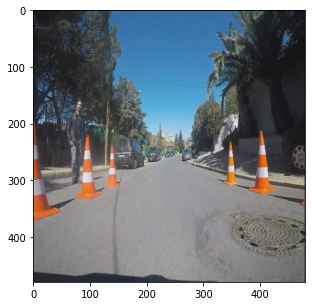

In [25]:
test_dataset = ConeImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))

# pick one image from the test set
img, target = test_dataset[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
  prediction = model([img.to(device)])[0]
    
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)

In [28]:
torch.save(model, './outmodel.pth')

In [29]:
torch.save(model.state_dict(), './outmodelstate.pth')